### Importing modules and setting up matplotlib to render inside the notebook

In [1]:
%matplotlib inline

import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

### Defining the NeuralNetwork class

In [2]:
class NeuralNetwork:
    def __init__(self, layers, relu_alpha=0.01):
        """
        Constructor.

        Args:
            layers: Number of neurons for each layer.
            relu_alpha: Parameter of leaky ReLU (set to 0 for default ReLU behaviour).

        Returns:
            New NeuralNetwork instance.
        """
        self.layers = layers
        self.relu_alpha = relu_alpha
        self.W = [None] * (len(layers) - 1) # Weight matrix
        self.dW = [None] * (len(layers) - 1) # Derivative of loss function with respect to weight matrix
        self.b = [None] * (len(layers) - 1) # Bias vector
        self.db = [None] * (len(layers) - 1) # Derivative of loss function with respect to bias vector
        self.z = [None] * len(layers) # Summed value of neurons before applying activation function
        self.a = [None] * len(layers) # Activation of neurons
        
        for i in range(1, len(layers)):
            # Using He initialization. Link at the sources section.
            self.W[i - 1] = np.random.randn(layers[i - 1], layers[i]) * np.sqrt(2 / layers[i - 1])
            self.b[i - 1] = np.random.randn(1, layers[i]) * np.sqrt(2 / layers[i - 1])
            

    def forward(self, X):
        """
        Runs network.

        Args:
            X: Input with shape==(N, D) (N: number of input rows, D: input dimension).

        Returns:
            Softmax probabilities of classes with shape==(N, K) (K: number of classes).
        """
        self.a[0] = X
        
        for i in range(len(self.W)):
            self.z[i + 1] = self.a[i].dot(self.W[i]) + self.b[i]
            
            if i == len(self.W) - 1:
                self.probs = np.e**self.z[i + 1]
                self.probs = self.probs / np.sum(self.probs, axis=1, keepdims=True)
                return self.probs
            
            self.a[i + 1] = self.z[i + 1].copy()
            self.a[i + 1][self.a[i + 1] < 0] *= self.relu_alpha
    
    
    def backward(self, y):
        """
        Computes gradient based on previous forward run.

        Args:
            y: One-hot encoded target output labels.

        Returns:
            None.
        """
        dz = (self.probs - y) / len(y)
        
        for i in reversed(range(len(self.W))):
            self.dW[i] = self.a[i].T.dot(dz)
            self.db[i] = dz.sum(axis=0, keepdims=True)
            
            if i == 0:
                break

            da = dz.dot(self.W[i].T)
            dz = da
            dz[self.z[i] < 0] *= self.relu_alpha
        
        
    def step(self, lr):
        """
        Performs one step of gradient descent.

        Args:
            lr: Learning rate.

        Returns:
            None.
        """
        for i in range(len(self.W)):
            self.W[i] -= self.dW[i] * lr
            self.b[i] -= self.db[i] * lr


    def check_gradient(self, X, y):
        """
        Checks gradient by comparing it to numerical gradient.

        Args:
            X: Input with shape==(N, D) (N: number of input rows, D: input dimension).
            y: One-hot encoded target output labels.

        Returns:
            None.
        """
        h = 10**-6
        threshold = 10**-6
        
        for k in range(len(self.W)):
            for i in range(self.W[k].shape[0]):
                for j in range(self.W[k].shape[1]):
                    old = self.W[k][i, j]
                    self.W[k][i, j] = old - h
                    probs = self.forward(X)
                    loss1 = -np.log((probs * y).sum(axis=1)).mean()
                    
                    self.W[k][i, j] = old + h
                    probs = self.forward(X)
                    loss2 = -np.log((probs * y).sum(axis=1)).mean()
                    
                    grad = (loss2 - loss1) / (2 * h)
                    self.W[k][i, j] = old
                    
                    if np.abs(grad - self.dW[k][i, j]) > threshold:
                        raise ValueError('Incorrect gradient.')
            
            for j in range(self.b[k].shape[1]):
                old = self.b[k][0, j]
                self.b[k][0, j] = old - h
                probs = self.forward(X)
                loss1 = -np.log((probs * y).sum(axis=1)).mean()

                self.b[k][0, j] = old + h
                probs = self.forward(X)
                loss2 = -np.log((probs * y).sum(axis=1)).mean()

                grad = (loss2 - loss1) / (2 * h)
                self.b[k][0, j] = old
                
                if np.abs(grad - self.db[k][0, j]) > threshold:
                    raise ValueError('Incorrect gradient.')

### Function to generate sample data
We are generating a 2D data set. The data points lie on concentric rings so they are not linearly separable. Because of this a neural network with at least one hidden layer is needed to classify them correctly.

In [3]:
def generate_data(D, K, KN):
    """
    Generates sample data.
    
    Args:
        D: Input dimension.
        K: Number of classes.
        KN: Number of instances per class.
        
    Returns:
        Sample X with shape==(K*KN, D) and y with shape==(K*KN, K).
    """
    N = K * KN
    X = np.zeros((N, D))
    y = np.zeros((N, K))

    for i in range(K):
        angle = np.random.uniform(0, 2 * np.pi, KN)
        noise = np.random.randn(KN) * 0.2
        X[i*KN:(i+1)*KN, 0] = np.cos(angle) * (i + 0.4 + noise)
        X[i*KN:(i+1)*KN, 1] = np.sin(angle) * (i + 0.4 + noise)
        y[i*KN:(i+1)*KN, i] = 1

    return X, y

### Generate training data and plot it

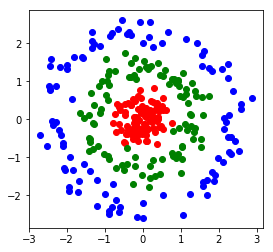

In [4]:
np.random.seed(0) # Random seed for reproducibility
gradient_checking_enabled = False
D = 2
K = 3
KN = 100

tr_X, tr_y = generate_data(D, K, KN)
plt.axes().set_aspect('equal', 'box')
plt.plot(tr_X[:KN, 0], tr_X[:KN, 1], 'ro')
plt.plot(tr_X[KN:2*KN, 0], tr_X[KN:2*KN, 1], 'go')
plt.plot(tr_X[2*KN:, 0], tr_X[2*KN:, 1], 'bo')
plt.show()

### Create neural network and run the training process
One hidden layer consisting of 16 neurons should be adequate to classify the data points.

Epoch #0, loss: 2.4382471477573713
Epoch #10, loss: 0.8378149610002715
Epoch #20, loss: 0.7027833086183445
Epoch #30, loss: 0.6074738356608591
Epoch #40, loss: 0.5337397845795918
Epoch #50, loss: 0.47451257738974506
Epoch #60, loss: 0.4260190652135541
Epoch #70, loss: 0.38546384333638306
Epoch #80, loss: 0.3511661841057892
Epoch #90, loss: 0.32184228949024174
Epoch #100, loss: 0.2965299726678111
Epoch #110, loss: 0.2745700171337105
Epoch #120, loss: 0.2553764194972763
Epoch #130, loss: 0.23848044718208125
Epoch #140, loss: 0.2236001015987449
Epoch #150, loss: 0.21031697557701137
Epoch #160, loss: 0.19839183097946334
Epoch #170, loss: 0.18765527521656752
Epoch #180, loss: 0.177939392242547
Epoch #190, loss: 0.16916858247457575
Epoch #200, loss: 0.1612081218557221


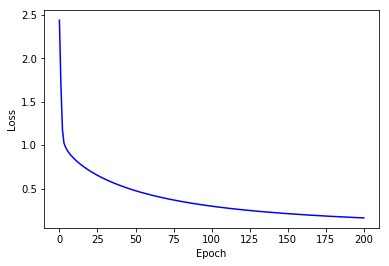

In [5]:
net = NeuralNetwork([D, 16, K])
epochs = 201
loss_values = []

for i in range(epochs):
    probs = net.forward(tr_X)
    loss = -np.log((probs * tr_y).sum(axis=1)).mean()
    net.backward(tr_y)
    
    if gradient_checking_enabled:
        net.check_gradient(tr_X, tr_y)
    
    net.step(0.2)
    loss_values.append(loss)
    print(f'Epoch #{i}, loss: {loss}') if i % 10 == 0 else None

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(epochs), loss_values, 'b-')
plt.show()

### Generate test data and measure the accuracy of the trained neural network

In [6]:
test_X, test_y = generate_data(D, K, KN)
probs = net.forward(test_X)
preds = probs.argmax(axis=1)
correct = (probs.argmax(axis=1) == test_y.argmax(axis=1)).sum()
print(f'Test set accuracy: {100 * correct / (K * KN):.2f}%')

Test set accuracy: 98.67%


### Visualize the trained neural network on the test data

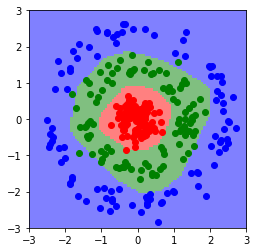

In [7]:
coord_range = np.linspace(-3, 3, 100)
img = []

for c2, c1 in itertools.product(coord_range, coord_range):
        probs = net.forward(np.array([[c1, c2]]))
        predicted_class = np.argmax(probs)
        img.append(predicted_class)

img = np.array(img).reshape(100, 100)        
colors = ['red', 'green', 'blue']

plt.plot(test_X[:KN, 0], test_X[:KN, 1], 'ro')
plt.plot(test_X[KN:2*KN, 0], test_X[KN:2*KN, 1], 'go')
plt.plot(test_X[2*KN:, 0], test_X[2*KN:, 1], 'bo')
plt.imshow(img, cmap=LinearSegmentedColormap.from_list('rgb', colors, N=K), alpha=0.5,
           origin='lower', extent=[-3, 3, -3, 3])
plt.show()

### Sources used
https://math.stackexchange.com/questions/945871/derivative-of-softmax-loss-function  
https://medium.com/usf-msds/deep-learning-best-practices-1-weight-initialization-14e5c0295b94

### Todo
* Add loss function for regression
* Add regularization (L1, L2)
* Add more selectable activation functions (logistic, tanh, elu)